# Topic: Bike Sharing Demand for Capital Bikeshare in Washington D.C.

## Part 1: Clean the dataset and create graphs to explore the trend

In [44]:
#Ignoring all the warnings that come
import warnings
warnings.filterwarnings('ignore')

#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns 
from sklearn.cross_validation import train_test_split
from datetime import datetime
import statsmodels.formula.api as sm

#Load Data with pandas, and parse the first column into datetime

url = "https://drive.google.com/uc?export=download&id=1sqr3X9W1yRjQLMbaf88TuARecS4wtfft"  #Public URL for the dataset
train = pd.read_csv(url, parse_dates=[0])


# Data Fields

- Datetime: hourly date + timestamp
- Season: 1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall
- Holiday: whether the day is considered a holiday
- Workingday: whether the day is neither a weekend nor holiday
- Weather:
          1: Clear, Few clouds, Partly cloudy, Partly cloudy  (Clear)
          2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (Mist)
          3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds                (Rainy)
          4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (Stormy)
- Temp: temperature in Celsius
- Atemp: "feels like" temperature in Celsius
- Humidity: relative humidity
- Windspeed: wind speed
- Casual: number of non-registered user rentals initiated
- Registered: number of registered user rentals initiated
- Count: number of total rentals

In [45]:
#process the timestamp into year, month, hour and weekday
temp = pd.DatetimeIndex(train['datetime'])
train['year'] = temp.year
train['month'] = temp.month
train['hour'] = temp.hour
train['weekday'] = temp.weekday
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


In [46]:
#Define features vector

features = ['season', 'holiday', 'workingday', 'weather',
        'temp', 'atemp', 'humidity', 'windspeed', 'year',
         'month', 'weekday', 'hour']

Text(0.5,1,'Histogram of log(rentals)')

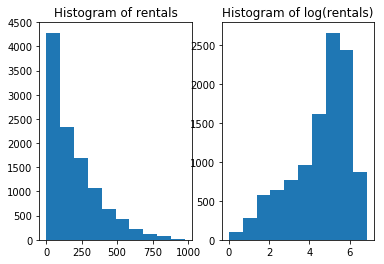

In [47]:
#plot the histogram of rental count and log of rental count
rentals = train['count']

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist((rentals))
ax1.set_title('Histogram of rentals')
ax2.hist(np.log(rentals))
ax2.set_title('Histogram of log(rentals)')

The rentals variable is distributed to be skewed to the right; while log(rentals) variable is distributed to be skewed to the left.

# Data Cleaning

Two steps done to clean the data set:

1) As we can see the rentals distribution is skewed, as a first measure of data cleaning we remved the outliers from the dataset. Outliers were considered to be those values of rentals which were greater than I3+1.5*IQR.

2) Since the windspeed column has some zeros values associated with it, so we removed the rows where windspeed=0

In [48]:
rentals_describe = train['count'].describe()

IQR = rentals_describe['75%'] - rentals_describe['25%']
outlier = rentals_describe['75%'] + 1.5*IQR

train = train[train['count']<=outlier]

# Since we see that windspeed not much correlation with the rentals count and it has lot of zeros\
# so we can first anlyse the results by dropping the windspeed column

train = train[(train['windspeed'] != 0)]


In [49]:
#Creating columns with labelled data for plotting on graphs

#labelling season
def f1(row):
    if row['season'] == 1:
        val = 'Winter'
    elif row['season'] == 2:
        val = 'Spring'
    elif row['season'] == 3:
        val = 'Summer'        
    elif row['season'] == 4:
        val = 'Fall'
    return val
train['season.'] = train.apply(f1, axis=1)

#Labelling weather
def f2(row):
    if row['weather'] == 1:
        val = 'Clear'
    elif row['weather'] == 2:
        val = 'Sunny'
    elif row['weather'] == 3:
        val = 'Rainy'        
    elif row['weather'] == 4:
        val = 'Stormy'
    return val
train['weather.'] = train.apply(f2, axis=1)

#Labelling weekday
def f3(row):
    if row['weekday'] == 0:
        val = 'Mon'
    elif row['weekday'] == 1:
        val = 'Tue'
    elif row['weekday'] == 2:
        val = 'Wed'        
    elif row['weekday'] == 3:
        val = 'Thu'
    elif row['weekday'] == 4:
        val = 'Fri'
    elif row['weekday'] == 5:
        val = 'Sat'        
    elif row['weekday'] == 6:
        val = 'Sun'    
    return val
train['weekday.'] = train.apply(f3, axis=1)

#Labelling holiday,workingday
train['holiday.'] = np.where(train['holiday']==1, 'Holiday', 'No Holiday')
train['workingday.'] = np.where(train['workingday']==1, 'Working Day', 'No Working Day')

#Labelling month
import calendar
train['month.'] = train['month'].apply(lambda x: calendar.month_abbr[x])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,year,month,hour,weekday,season.,weather.,weekday.,holiday.,workingday.,month.
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,...,2011,1,5,5,Winter,Sunny,Sat,No Holiday,No Working Day,Jan
10,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,...,2011,1,10,5,Winter,Clear,Sat,No Holiday,No Working Day,Jan
11,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,...,2011,1,11,5,Winter,Clear,Sat,No Holiday,No Working Day,Jan
12,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,...,2011,1,12,5,Winter,Clear,Sat,No Holiday,No Working Day,Jan
13,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,...,2011,1,13,5,Winter,Sunny,Sat,No Holiday,No Working Day,Jan


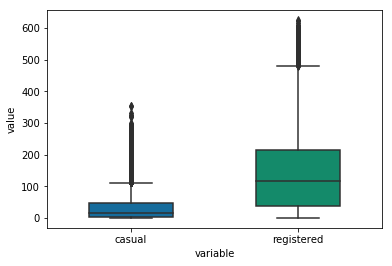

In [50]:
#plotting the box plot for casual vs registered users
df = train[['casual','registered']]
sns.boxplot(x="variable", y="value", data=pd.melt(df),width=0.5,palette="colorblind")
plt.show()

From the above graph, it can be seen that the usage of bike rentals is far more high for registered users as compared to casual users

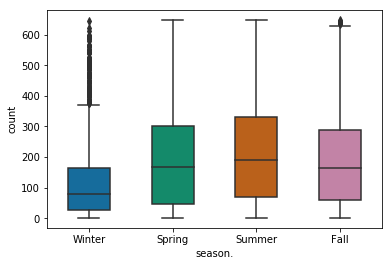

In [51]:
#grouping by season, plot the box plot
season_group= (train.groupby("season."))["count"].sum()
season_group.reset_index(name="total_rentals")
sns.boxplot(y='count',x='season.',data=train,width=0.5,palette="colorblind")
plt.show()

The count of bike rentals is lowest in winter and highest in summer. However, there are a lot of outliers in Winter and Fall.

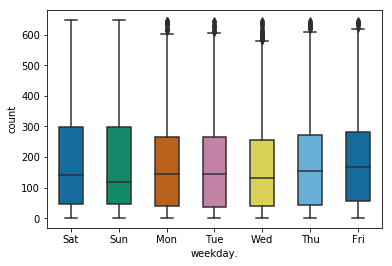

In [52]:
#grouping by weekday, plot the box plot
weekday_group= (train.groupby("weekday."))["count"].sum()
weekday_group.reset_index(name="total_rentals")
sns.boxplot(y='count',x='weekday.',data=train,width=0.5,palette="colorblind")
#deep,muted,pastel,bright,dark,colorblind,Blues,BuGn_r,GnBu_d
plt.show()

Although the count seems pretty constant throughout the week, it slightly more on the weekend. Also, there are a lot of outliers from Monday to Friday and no outliers during the weekend.

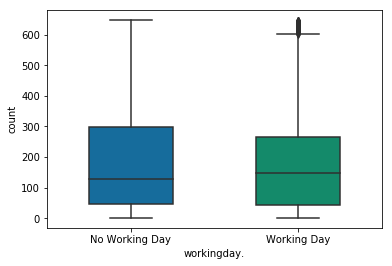

In [53]:
#seeing the difference between workday and non-workday
wd_group= (train.groupby("workingday."))["count"].sum()
wd_group.reset_index(name="total_rentals")
sns.boxplot(y='count',x='workingday.',data=train,width=0.5,palette="colorblind")
plt.show()

A higher bike rentals count can be seen on a non-working day but the median value of the count is higher on a working day.

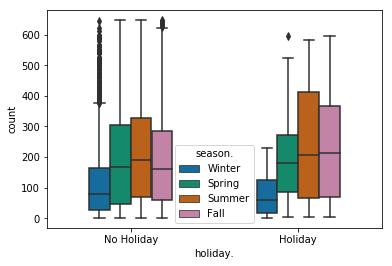

In [54]:
#group by season and see the difference between holiday and non-holiday
sns.boxplot(y='count',x='holiday.',data=train,hue="season.",width=0.5,palette="colorblind")


There are significan outliers on a winter non-holiday. The count in fall has a higher median value on holidays as compared to the non-holidays. For the other seasons, the median is almost same but the range is higher for holidays in the summer.

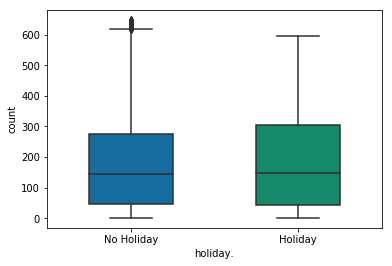

In [55]:
#seeing the difference between holiday and non-holiday
holiday_group= (train.groupby("holiday."))["count"].sum()
holiday_group.reset_index(name="total_rentals")
sns.boxplot(y='count',x='holiday.',data=train,width=0.5,palette="colorblind")
plt.show()

There is not much difference between holiday and non-holiday, except that there are outliers for non-holiday group.

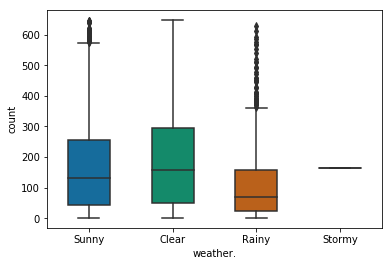

In [56]:
#grouping by weather and plot the box plot
weather_group= (train.groupby("weather."))["count"].sum()
weather_group.reset_index(name="total_rentals")
sns.boxplot(y='count',x='weather.',data=train,width=0.5,palette="colorblind")
plt.show()

The number of bikes rented decreases as the weather gets more severe. In the stormy kind of weather, the count is negligible. The weather in which users highly favor bike riding is clear and sunny weather.

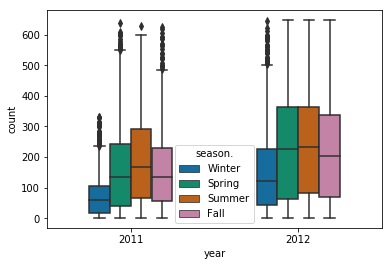

In [57]:
#group by season and see the difference between the 2 years
sns.boxplot(y='count',x='year',data=train,hue='season.',width=0.5,palette="colorblind")

There is considerable increase in the bike rentals from 2011 to 2012 in each season of the year.

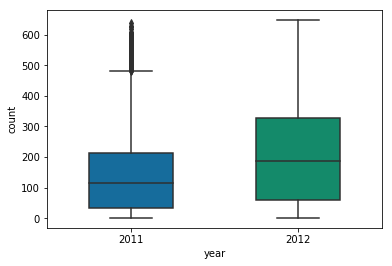

In [58]:
#annual change
year_group= (train.groupby("year"))["count"].sum()
year_group.reset_index(name="total_rentals")
sns.boxplot(y='count',x='year',data=train,width=0.5,palette="colorblind")
plt.show()

There are more bikes rented in 2012 than in 2011, which may indicate that there is an impact of time on the dependent variable.

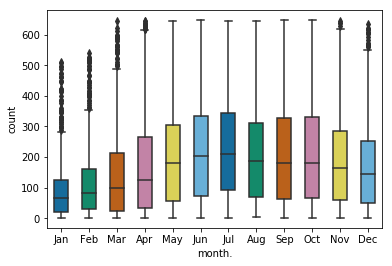

In [59]:
#monthly change
month_group= (train.groupby("month."))["count"].sum()
month_group.reset_index(name="total_rentals")
sns.boxplot(y='count',x='month.',data=train,width=0.5,palette="colorblind")
plt.show()

The change according to month follows the trend found according to season.

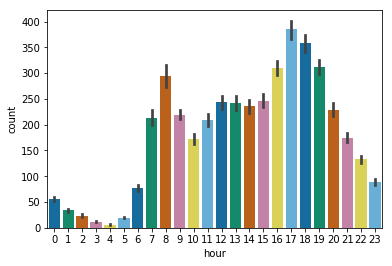

In [60]:
#hourly change expressed in bar graph
hour_group= (train.groupby("hour"))["count"].sum()
hour_group.reset_index(name="total_rentals")
sns.barplot(y='count',x='hour',data=train,palette="colorblind")
plt.show()

The rush hour is 8 o'clock in the morning and 5 to 6 o'clock in the afternoon.

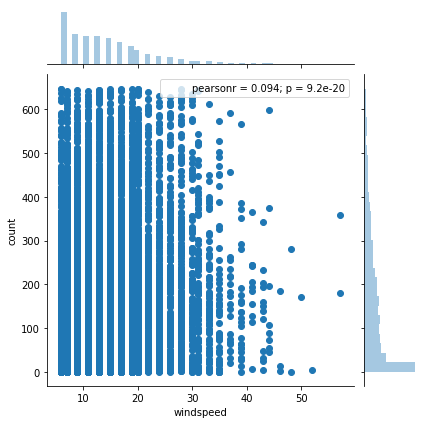

In [61]:
#see if there is relation between windspeed and count
sns.jointplot(y='count',x='windspeed',data=train)

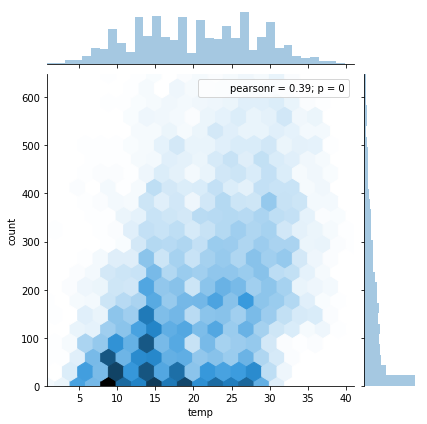

In [62]:
#see if there is relation between temperature and count
sns.jointplot(y='count',x='temp',data=train,kind='hex',gridsize=20)

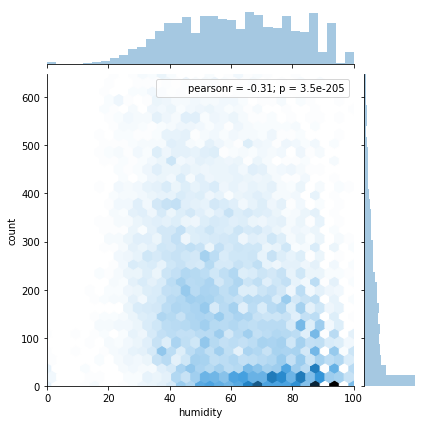

In [63]:
#see if there is relation between humidity and count
sns.jointplot(y='count',x='humidity',kind='hex',data=train)

## Part 2: Find correlation between variables for the regression

In [64]:
corr = train.corr()
corr.style.background_gradient().set_precision(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
season,1,0.03,-0.009,0.02,0.3,0.3,0.2,-0.1,0.1,0.2,0.2,-0.002,1,-0.0006,-0.007
holiday,0.03,1,-0.2,0.003,-0.01,-0.01,-0.0008,0.01,0.04,-0.008,0.007,0.02,0.0001,0.01,-0.2
workingday,-0.009,-0.2,1,0.03,0.03,0.02,-0.02,0.02,-0.3,0.1,-0.02,-0.01,-0.0006,-0.001,-0.7
weather,0.02,0.003,0.03,1,-0.05,-0.05,0.4,-0.01,-0.1,-0.1,-0.1,-0.02,0.03,-0.03,-0.05
temp,0.3,-0.01,0.03,-0.05,1,1,-0.03,-0.04,0.5,0.3,0.4,0.03,0.3,0.1,-0.04
atemp,0.3,-0.01,0.02,-0.05,1,1,-0.01,-0.07,0.5,0.3,0.4,0.03,0.3,0.1,-0.04
humidity,0.2,-0.0008,-0.02,0.4,-0.03,-0.01,1,-0.3,-0.3,-0.3,-0.3,-0.06,0.2,-0.3,-0.02
windspeed,-0.1,0.01,0.02,-0.01,-0.04,-0.07,-0.3,1,0.08,0.09,0.09,-0.04,-0.1,0.1,-0.03
casual,0.1,0.04,-0.3,-0.1,0.5,0.5,-0.3,0.08,1,0.5,0.7,0.1,0.1,0.3,0.3
registered,0.2,-0.008,0.1,-0.1,0.3,0.3,-0.3,0.09,0.5,1,1,0.2,0.2,0.4,-0.07


hour and temp has strongest correlation with the count of bike rentals. But hour and temp also have significant correlation with each other. 

In [65]:
dataY = train['count'] #target variable
dataX = train.drop(columns=['count'],axis=1) #independent variables

In [66]:
# We divide the dat ainto 80% and 20% for training and validation purpose.
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(train,dataY, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

#convert variables into categories
X_train['season'] = X_train['season'].astype('category')
X_train['hour'] = X_train['hour'].astype('category')
X_train['weekday'] = X_train['weekday'].astype('category')
X_train['month'] = X_train['month'].astype('category')


(7440, 22) (7440,)
(1861, 22) (1861,)


## Part 3: Regression Analysis

In [67]:
#1st try of regression with all the variables
model_fit = sm.ols(formula="count ~ hour + season + month + weather + temp +windspeed", data=X_train).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     332.0
Date:                Sat, 21 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:39:34   Log-Likelihood:                -44565.
No. Observations:                7440   AIC:                         8.921e+04
Df Residuals:                    7402   BIC:                         8.947e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -39.1964      8.018     -4.889      

Adj. R squared is 0.62 here. Some random variables have high p value or having an insignificant linear relationship to the number of bike get rented

In [68]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)


Text(0,0.5,'Residuals')

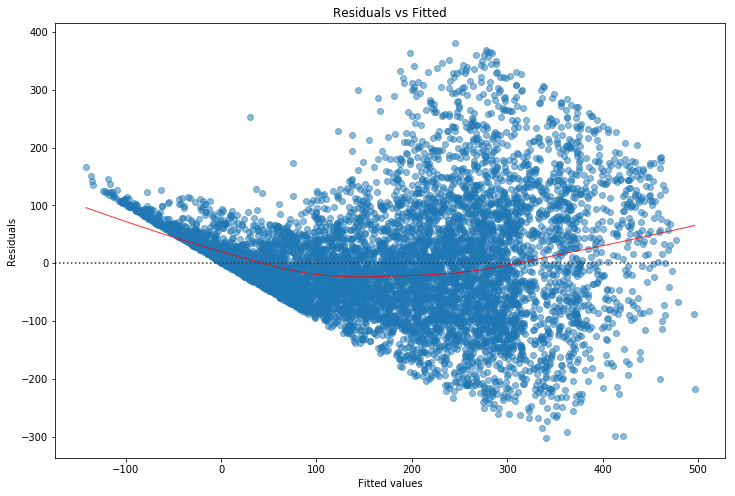

In [69]:
# plot the residuals
residualplot = plt.figure(1)
residualplot.set_figheight(8)
residualplot.set_figwidth(12)

residualplot.axes[0] = sns.residplot(model_fitted_y, y_train, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

residualplot.axes[0].set_title('Residuals vs Fitted')
residualplot.axes[0].set_xlabel('Fitted values')
residualplot.axes[0].set_ylabel('Residuals')


Seeing heteroskedasticity in the residual plot. The pattern in the residuals plot indicate that this linear regression model is not good.

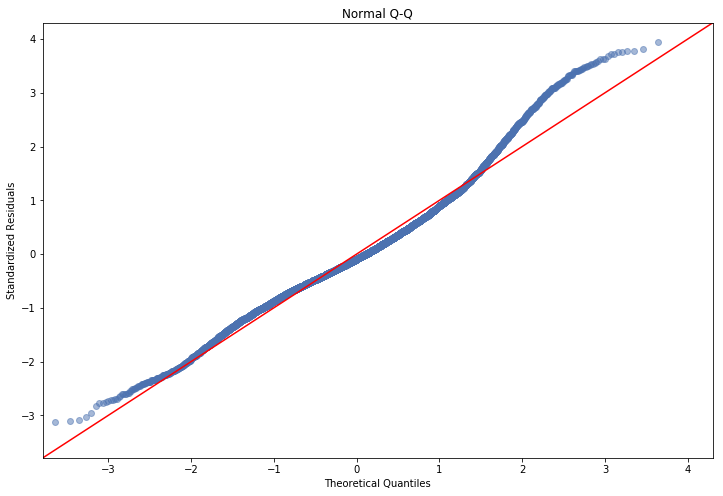

In [70]:
#plot the qq plot to find the residule have normal distribution
from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');


Residuals are not normal distributed since the blue dots are not lying on the straight line. We can conclude that this is not a fitted model.

To improve the model, we next fit the model by taking lograithmic of number of rentals as the dependent variable.

In [71]:
#2nd try of regression analysis by changing the dependent variable to log
X_train['logCount'] = np.log(X_train['count'])
y_train = X_train['logCount']

X_test['logCount'] = np.log(X_test['count'])
y_test = X_test['logCount']

model_fit = sm.ols(formula="logCount ~ hour + season + month + weather + temp +windspeed", data=X_train).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               logCount   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     771.6
Date:                Sat, 21 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:39:44   Log-Likelihood:                -7498.2
No. Observations:                7440   AIC:                         1.507e+04
Df Residuals:                    7402   BIC:                         1.534e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9838      0.055     54.252      

We got higher value in Adj. R squared (=0.79). However, there are still some month variables that have insignificant impact on the dependent variable.

In [72]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)



Text(0,0.5,'Residuals')

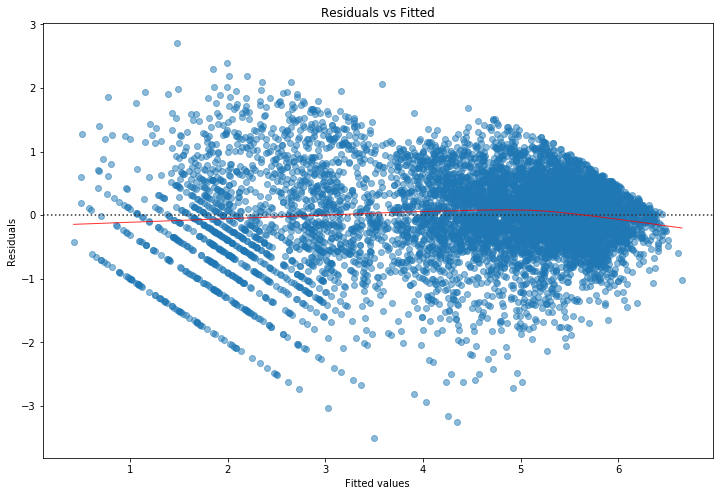

In [73]:
#conduct the residule plot
residualplot = plt.figure(1)
residualplot.set_figheight(8)
residualplot.set_figwidth(12)

residualplot.axes[0] = sns.residplot(model_fitted_y, y_train, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

residualplot.axes[0].set_title('Residuals vs Fitted')
residualplot.axes[0].set_xlabel('Fitted values')
residualplot.axes[0].set_ylabel('Residuals')


It can be seen in the above graph that this graph has a less uniform pattern than the previous plot.


Text(0,0.5,'Standardized Residuals')

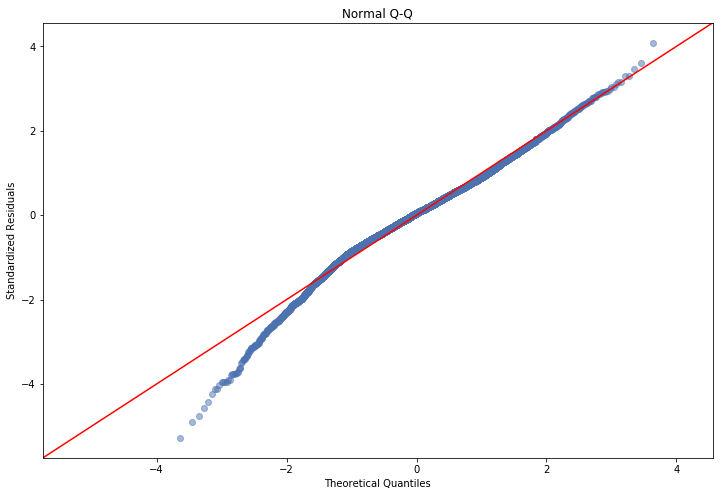

In [74]:
#plot the qq plot
from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals')


Seeing a better patten in the residual plot. The points are more normal distributed comparing to that in the last model.

In [75]:
#Root Mean Squared Logarithmic Error
def rmsle(prediction, actual):
    log1 = np.nan_to_num(np.array([v for v in prediction]))
    log2 = np.nan_to_num(np.array([v for v in actual]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [76]:
#Performing the predictions using the fitted model and computing MSE

ypred = model_fit.predict(X_test)
predictions = ypred.values

i=0
for v in predictions:
    if predictions[i]<0:
        predictions[i] = 0
    i = i+1    

RMSLE = rmsle(predictions,y_test)
print(" The Mean Squared error for this model is:",RMSLE)


 The Mean Squared error for this model is: 0.6741360506452295


Text(0.5,1,'Linear Regression Model')

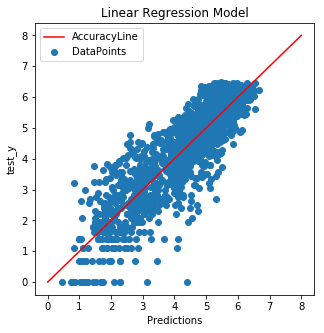

In [77]:
# check the model in the test data
plt.figure(figsize=(5, 5))
plt.scatter(predictions,y_test)
plt.legend(["DataPoints"])
plt.plot( [0,8],[0,8], color='red')
plt.legend(["AccuracyLine","DataPoints"])
plt.xlabel('Predictions')
plt.ylabel('test_y')
plt.title('Linear Regression Model')


As in the graph, we can say that the model fit pretty well.

## Part 4: Time Series Consideration in the regression analysis

As a further extension we also include the timeseries impact on the rentals, since the number of rentals increases month by month.

The way we do this is make the month column grow linearly over each month.

In [78]:
train["month"] = train["datetime"].dt.month

def timeseries_month(df):
    year = df.year
    month = df.month
    if year>2011:
        month = df.month+ 12*(year-2011)
    
    return month

train['month'] = train.apply(timeseries_month,axis=1)
X_train['month'] = X_train.apply(timeseries_month,axis=1)
X_test['month'] = X_test.apply(timeseries_month,axis=1)


In [79]:
X_train['logCount'] = np.log(X_train['count'])
y_train = X_train['logCount']

X_test['logCount'] = np.log(X_test['count'])
y_test = X_test['logCount']

model_fit = sm.ols(formula="logCount ~ hour + season + month + weather + temp +windspeed", data=X_train).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               logCount   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1115.
Date:                Sat, 21 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:39:54   Log-Likelihood:                -7024.3
No. Observations:                7440   AIC:                         1.411e+04
Df Residuals:                    7409   BIC:                         1.432e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7956      0.049     57.222      

The Adj. R squared is 0.82, which is improved from the last model. We now dont have any insignificant variables as there is no high p value. It is better to consider time change in our model.

Root Mean Square Error (MSE) for this model: 0.6272351503236125


Text(0.5,1,'Linear Regression Model')

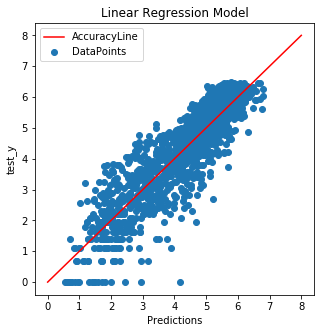

In [80]:
ypred = model_fit.predict(X_test)
predictions = ypred.values

i=0
for v in predictions:
    if predictions[i]<0:
        predictions[i] = 0
    i = i+1    

RMSLE = rmsle(predictions,y_test)
print("Root Mean Square Error (MSE) for this model:",RMSLE)

#test the model in the test data
plt.figure(figsize=(5, 5))
plt.scatter(predictions,y_test)
plt.legend(["DataPoints"])
plt.plot( [0,8],[0,8], color='red')
plt.legend(["AccuracyLine","DataPoints"])
plt.xlabel('Predictions')
plt.ylabel('test_y')
plt.title('Linear Regression Model')


As in the graph, we can say that the model fit pretty well.

## Part 5: Analyzing Number of Observations on the run time of regression

Since the number of rows in the dataset is only about 10000, for analyzing the time taken for regression what we do is concat the dataset to form double, quadraple and even bigger datasets.

We then see how time taken for the regression changes according to the increase in data size

In [81]:
import time
import profile

profile.run('sm.ols(formula="logCount ~ hour + season + month + weather + temp +windspeed", data=X_train).fit()')

#In the profiler results we see that the fit() function takes a very high cumulative time to process.

         13030 function calls (12686 primitive calls) in 0.141 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 :0(__array_prepare__)
      6/2    0.000    0.000    0.016    0.008 :0(__import__)
       64    0.000    0.000    0.000    0.000 :0(__new__)
        1    0.000    0.000    0.000    0.000 :0(_getframe)
        1    0.000    0.000    0.000    0.000 :0(abs)
       30    0.016    0.001    0.016    0.001 :0(acquire_lock)
       44    0.000    0.000    0.000    0.000 :0(add)
        6    0.000    0.000    0.000    0.000 :0(all)
       16    0.000    0.000    0.000    0.000 :0(allocate_lock)
       49    0.000    0.000    0.000    0.000 :0(any)
      329    0.000    0.000    0.000    0.000 :0(append)
       17    0.000    0.000    0.000    0.000 :0(arange)
  149/135    0.000    0.000    0.000    0.000 :0(array)
        5    0.000    0.000    0.000    0.000 :0(astype)
       16

        8    0.000    0.000    0.000    0.000 design_info.py:213(__init__)
        2    0.000    0.000    0.000    0.000 design_info.py:271(__init__)
        2    0.000    0.000    0.000    0.000 design_info.py:361(<listcomp>)
        8    0.000    0.000    0.000    0.000 design_info.py:401(column_names)
        7    0.000    0.000    0.000    0.000 design_info.py:77(__init__)
        9    0.000    0.000    0.000    0.000 dtypes.py:266(construct_from_string)
        8    0.000    0.000    0.000    0.000 dtypes.py:363(categories)
        2    0.000    0.000    0.000    0.000 dtypes.py:401(__new__)
        2    0.000    0.000    0.000    0.000 dtypes.py:459(construct_from_string)
       10    0.000    0.000    0.000    0.000 dtypes.py:584(is_dtype)
        5    0.000    0.000    0.000    0.000 dtypes.py:675(construct_from_string)
       17    0.000    0.000    0.000    0.000 dtypes.py:707(is_dtype)
       15    0.000    0.000    0.000    0.000 eval.py:136(__init__)
        7    0.000    

       22    0.000    0.000    0.000    0.000 util.py:321(__iter__)
       13    0.000    0.000    0.000    0.000 util.py:324(push_back)
       70    0.000    0.000    0.000    0.000 util.py:327(next)
       14    0.000    0.000    0.000    0.000 util.py:335(peek)
       14    0.000    0.000    0.000    0.000 util.py:343(has_more)
        4    0.000    0.000    0.000    0.000 util.py:616(pandas_Categorical_categories)
        2    0.000    0.000    0.016    0.008 util.py:628(pandas_Categorical_codes)
       27    0.000    0.000    0.000    0.000 util.py:652(safe_is_pandas_categorical_dtype)
       11    0.000    0.000    0.000    0.000 util.py:658(safe_is_pandas_categorical)
       16    0.000    0.000    0.000    0.000 util.py:690(safe_issubdtype)
        1    0.000    0.000    0.000    0.000 wrapper.py:15(__init__)




In [82]:
%timeit -n 3 sm.ols(formula="logCount ~ hour + season + month + weather + temp +windspeed", data=X_train).fit()
duplicity = [2,4,6,8,16,32,64]  #Duplicity factor for dataset
time_taken=[]

for dup in duplicity:
    duplist = []
    for i in range(dup):
        duplist.append(X_train)
    result = pd.concat(duplist)
    time1 = time.time()
    model_fit = sm.ols(formula="logCount ~ hour + season + month + weather + temp +windspeed", data=result).fit()
    time2 = time.time()
    time_taken.append(time2-time1)
    


23.6 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


Text(0.5,1,'Linear Regression Model')

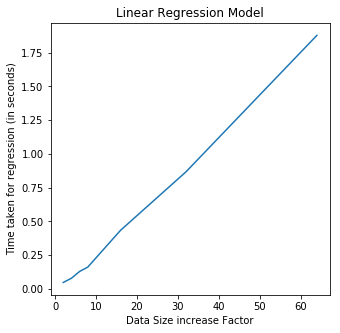

In [83]:
plt.figure(figsize=(5, 5))
plt.plot(duplicity,time_taken)
plt.xlabel('Data Size increase Factor')
plt.ylabel('Time taken for regression (in seconds)')
plt.title('Linear Regression Model')

If the dataset increase its size (currently by duplicating the factors of dataset), the time taken for regression will increase.